In [1]:
import matplotlib.pyplot as plt
import numpy
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

# np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import cv2
from keras.models import load_model
from sklearn import svm
from sklearn.svm import SVC
import joblib

In [5]:
import subprocess

# Upgrade Keras
subprocess.check_call(['pip', 'install', '--upgrade', 'keras'])

0

In [2]:
import keras
print(keras.__version__)
#print(tf.__version__)

3.0.5


In [2]:
# base_model = keras.applications.DenseNet201(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(224, 224, 3)
# )

#base_model = load_model(os.path.join('models', 'densenetmodel50epochs1000resample224size.keras'))
base_model = keras.saving.load_model(os.path.join('models', 'Densenetmodel50epochs1500resample224size.keras'))

C:\Users\jesse\scoop\apps\python\current\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1210 variables whereas the saved optimizer has 6 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [3]:
base_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        13,447 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,548,183 (208.08 MB)

 Trainable params: 18,106,375 (69.07 MB)

 Non-trainable params: 229,056 (894.75 KB)

 Optimizer params: 36,212,752 (138.14 MB)

In [8]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [3]:
#base_model.trainable = False

In [4]:
#base_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [3]:
dataset = pd.read_csv('project_dataset/HAM10000_metadata.csv')
SIZE = 224

In [4]:
labEnc = LabelEncoder()
labEnc.fit(dataset['dx'])
LabelEncoder()

dataset['label'] = labEnc.transform(dataset["dx"])
dataset.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
8768,HAM_0003911,ISIC_0030645,nv,histo,35.0,female,upper extremity,5
2842,HAM_0005371,ISIC_0028168,bcc,histo,65.0,female,face,1
56,HAM_0003569,ISIC_0027960,bkl,histo,75.0,male,unknown,2
1153,HAM_0007418,ISIC_0026313,df,consensus,50.0,male,lower extremity,3
1385,HAM_0000233,ISIC_0028219,mel,histo,45.0,male,upper extremity,4
6275,HAM_0005507,ISIC_0029159,nv,follow_up,35.0,male,trunk,5
6521,HAM_0007584,ISIC_0025139,nv,follow_up,35.0,female,trunk,5
8414,HAM_0005614,ISIC_0030397,nv,histo,35.0,female,trunk,5
9434,HAM_0001916,ISIC_0032721,nv,consensus,20.0,male,back,5
6172,HAM_0001003,ISIC_0028629,nv,follow_up,70.0,male,back,5


In [5]:
# Dataset is imbalanced, resample the classes to remove the imbalance
ds_0 = dataset[dataset['label'] == 0]
ds_1 = dataset[dataset['label'] == 1]
ds_2 = dataset[dataset['label'] == 2]
ds_3 = dataset[dataset['label'] == 3]
ds_4 = dataset[dataset['label'] == 4]
ds_5 = dataset[dataset['label'] == 5]
ds_6 = dataset[dataset['label'] == 6]

sample_num = 1000
ds_0_balanced = resample(ds_0, replace=True, n_samples=sample_num, random_state=42)
ds_1_balanced = resample(ds_1, replace=True, n_samples=sample_num, random_state=42)
ds_2_balanced = resample(ds_2, replace=True, n_samples=sample_num, random_state=42)
ds_3_balanced = resample(ds_3, replace=True, n_samples=sample_num, random_state=42)
ds_4_balanced = resample(ds_4, replace=True, n_samples=sample_num, random_state=42)
ds_5_balanced = resample(ds_5, replace=True, n_samples=sample_num, random_state=42)
ds_6_balanced = resample(ds_6, replace=True, n_samples=sample_num, random_state=42)

# Combine the datasets together
dataset_balanced = pd.concat(
    [ds_0_balanced, ds_1_balanced, ds_2_balanced, ds_3_balanced, ds_4_balanced, ds_5_balanced, ds_6_balanced])
# Check new distribution
dataset_balanced['label'].value_counts()

label
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
Name: count, dtype: int64

In [6]:
# Read images based on the image ID from the csv file
image_path = {os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join('all_images/', '*.jpg'))}

In [7]:
# Define the path and add as a new column
dataset_balanced['path'] = dataset['image_id'].map(image_path.get)

#use the path to read images, then convert them to 64,64 then add them to a new column called image
dataset_balanced['image'] = dataset_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [8]:
# Concert dataframe image attributes into a numpy array
X = np.asarray(dataset_balanced['image'].tolist())
# Scale values between 0-1 by dividing by the highest possible value (255)
X = X/255
# assign label values (what we are trying to predict) to Y, label is used instead of dx because label is an integer and the computer won't understand dx
Y = dataset_balanced['label']
# Convert to categorical as this is multiclass classification
Y_cat = to_categorical(Y,num_classes = 7)
# make training and testing partitions
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [9]:
features_train = base_model.predict(x_train)
features_test = base_model.predict(x_test)

165/165 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step


In [10]:
supportVect = SVC(kernel='linear')
supportVect.fit(features_train,y_train)

SVC(kernel='linear')

In [14]:
joblib.dump(supportVect, os.path.join('models', 'svm_model.joblib'))

['models\\svm_model.joblib']

In [11]:
y_pred = supportVect.predict(features_test)
cm = confusion_matrix(y_test,y_pred)

In [ ]:
labels = np.unique(y_test)
confusion_frame = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(8, 8))
sns.heatmap(data=confusion_frame, annot=True, square=True, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       262
           1       0.95      0.95      0.95       270
           2       0.87      0.90      0.88       233
           3       0.99      1.00      1.00       267
           4       0.84      0.88      0.86       234
           5       0.94      0.84      0.89       248
           6       1.00      1.00      1.00       236

    accuracy                           0.93      1750
   macro avg       0.93      0.93      0.93      1750
weighted avg       0.93      0.93      0.93      1750


In [ ]:
class_to_evaluate = 5
report = classification_report(y_test, y_pred, labels=[class_to_evaluate], target_names=[f'Class {class_to_evaluate}'])
report

In [80]:
print(report)

              precision    recall  f1-score   support

     Class 5       0.74      0.59      0.66       113

   micro avg       0.74      0.59      0.66       113
   macro avg       0.74      0.59      0.66       113
weighted avg       0.74      0.59      0.66       113


Text(0.5, 1.0, 'Confusion matrix')

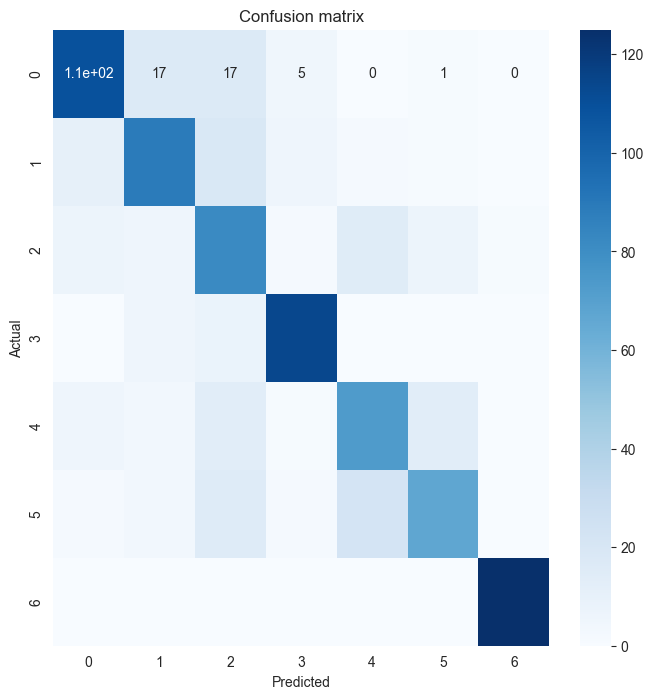

In [51]:
plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True,cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')

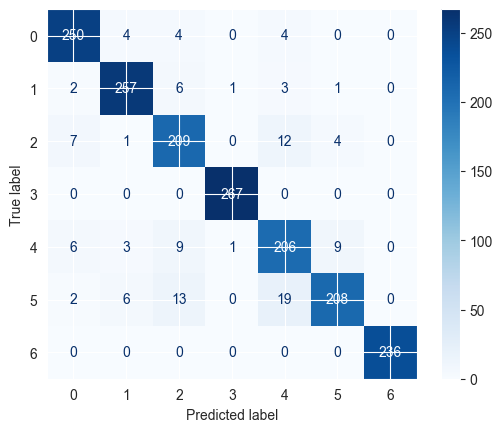

In [13]:
from sklearn import metrics

labels = np.unique(y_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)

cm_display.plot(cmap='Blues')
plt.show()

In [ ]:
print(cm)

In [ ]:
from sklearn.model_selection import GridSearchCV 

# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
			'kernel': ['rbf','linear','poly', 'sigmoid']} 

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 

#x_train = np.array([x.ravel() for x in x_train])

# fitting the model for grid search 
grid.fit(features_train, y_train) 

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.939 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.923 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.933 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.937 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.930 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.939 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.923 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.934 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.940 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.935 total time=   0.0s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.932 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=pol

In [ ]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

x_test =  np.array([x.ravel() for x in x_test])

grid_predictions = grid.predict(features_test) 

# print classification report 
print(classification_report(y_test, grid_predictions)) 


              precision    recall  f1-score   support

           0       0.80      0.73      0.76       149
           1       0.74      0.66      0.70       128
           2       0.51      0.66      0.58       120
           3       0.89      0.91      0.90       128
           4       0.65      0.63      0.64       112
           5       0.69      0.64      0.66       113
           6       1.00      0.99      1.00       125

    accuracy                           0.75       875
   macro avg       0.75      0.75      0.75       875
weighted avg       0.76      0.75      0.75       875


In [23]:
supportVect = SVC(kernel='rbf',gamma=1,C=1000)
supportVect.fit(features_train,y_train)

SVC(C=1000, gamma=1)

In [24]:
y_pred = supportVect.predict(features_test)
cm = confusion_matrix(y_test,y_pred)

In [25]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       149
           1       0.95      0.91      0.93       128
           2       0.86      0.90      0.88       120
           3       1.00      1.00      1.00       128
           4       0.86      0.85      0.85       112
           5       0.88      0.88      0.88       113
           6       1.00      1.00      1.00       125

    accuracy                           0.93       875
   macro avg       0.93      0.93      0.93       875
weighted avg       0.93      0.93      0.93       875


In [15]:
loaded_model = joblib.load(os.path.join('models', 'svm_model.joblib'))

In [16]:
prediction = loaded_model.predict(features_test)

In [17]:
prediction

array([6, 2, 2, ..., 2, 2, 3])